In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import KFold

import implicit
from implicit.datasets.movielens import get_movielens
from implicit.evaluation import leave_k_out_split
from implicit.evaluation import ndcg_at_k
from implicit.als import AlternatingLeastSquares


# MovieLens Dataset

In [60]:
def get_users_by_usage(ratings_df):
    labels = list(range(1, 8))
    popularity_cut = pd.qcut(ratings_df.groupby('user_id').movie_id.nunique(), 7)
    popularity_cut = popularity_cut.cat.rename_categories(labels)
    popularity_cut = pd.DataFrame(popularity_cut)
    popularity_cut = popularity_cut.reset_index(drop=False)
    popularity_cut.columns = ['user_id', 'usage']

    popularity_cut_counts = pd.DataFrame(popularity_cut.groupby('usage').count())
    popularity_cut_counts = popularity_cut_counts.reset_index(drop=False)
    popularity_cut_counts['percentage'] = popularity_cut_counts.user_id / popularity_cut_counts.user_id.sum()

    return popularity_cut, popularity_cut_counts

In [11]:
def get_divided_test_fold(ratings_df, test_index, sampling_rate=.2):
    test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
    test_df = test_fold_df.groupby('user_id').sample(frac=.2)
    test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), 'rating'] = 0
    
    return test_fold_df, test_df

In [18]:
def get_metric_dict(users, column, values=None):
    metric_dict = {}
    if not values:
        values = users[column].unique()
    for g in values:
        metric_dict[g] = []
    return metric_dict

In [15]:
def get_age_bins():
    age_bins = {}
    age_bins[1] = '1-17'
    age_bins[18] = '18-24'
    age_bins[25] = '25-34'
    age_bins[35] = '35-44'
    age_bins[45] = '45-49'
    age_bins[50] = '50-55'
    age_bins[56] = '56+'

    age_labels = list(age_bins.values())

    return age_bins, age_labels

## Preparation

In [12]:
variant = "1m"

titles, ratings = get_movielens(variant)
ratings = ratings.T

col_names = ["user_id", "movie_id", "rating", "matrix_position"]
ratings_df = pd.read_csv('./ml-1m/ratings.dat', delimiter='::', names=col_names, engine='python')

col_names = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv('./ml-1m/users.dat', delimiter='::', names=col_names, engine='python')

In [61]:
popularity_cut, popularity_cut_counts = get_users_by_usage(ratings_df)
age_bins, age_labels = get_age_bins()

## CV

In [19]:
ndcg_dict_age = get_metric_dict(users, 'age')
ndcg_dict_gender = get_metric_dict(users, 'gender')
ndcg_dict_usage = get_metric_dict(users, '', values=range(1, 8))

In [28]:
ndcg_dicts = {}
ndcg_dicts['age'] = get_metric_dict(users, 'age')
ndcg_dicts['gender'] = get_metric_dict(users, 'gender')
ndcg_dicts['usage'] = get_metric_dict(users, '', values=range(1, 8))

In [25]:
random_state=12345
n_splits=5

In [33]:
# divide ratings into 5 CV
# 0th column is 0, since user ids start with 1
kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(ratings)):
    print(f'Starting training num. {i}...')
    # train data is divided into two parts
    # in train_index, full user data is used for training
    # in test_index, 80% of user data is used for training and the rest 20% is used for testing
    test_train_df, test_test_df = get_divided_test_fold(ratings_df, test_index)

    train_data = ratings.copy()
    # blend out the 20% of test users data for testing
    # test data contains data used for training + 20% blended in train data
    train_data[test_test_df.user_id, test_test_df.movie_id] = 0

    model = AlternatingLeastSquares(factors=50, regularization=0.01)
    model.fit(train_data)
    print(f'Model trained, starting evaluation...')

    test_test_df = test_test_df.merge(users, how='left', on='user_id')
    test_test_df = test_test_df.merge(popularity_cut, how='left', on='user_id')

    for col, ndcg_dict in ndcg_dicts.items():
        print(f'Starting evaluation by {col} groups...')
        for a in test_test_df[col].unique():
            test_data = ratings[test_test_df[test_test_df[col] == a].user_id.unique()]
            ndcg_dict[a].append(ndcg_at_k(model, train_data, test_data, K=10))
        print(f'Evaluation by {col} finished...')

## User distributions


<AxesSubplot: title={'center': 'Distribution of users per gender'}, xlabel='gender', ylabel='count'>

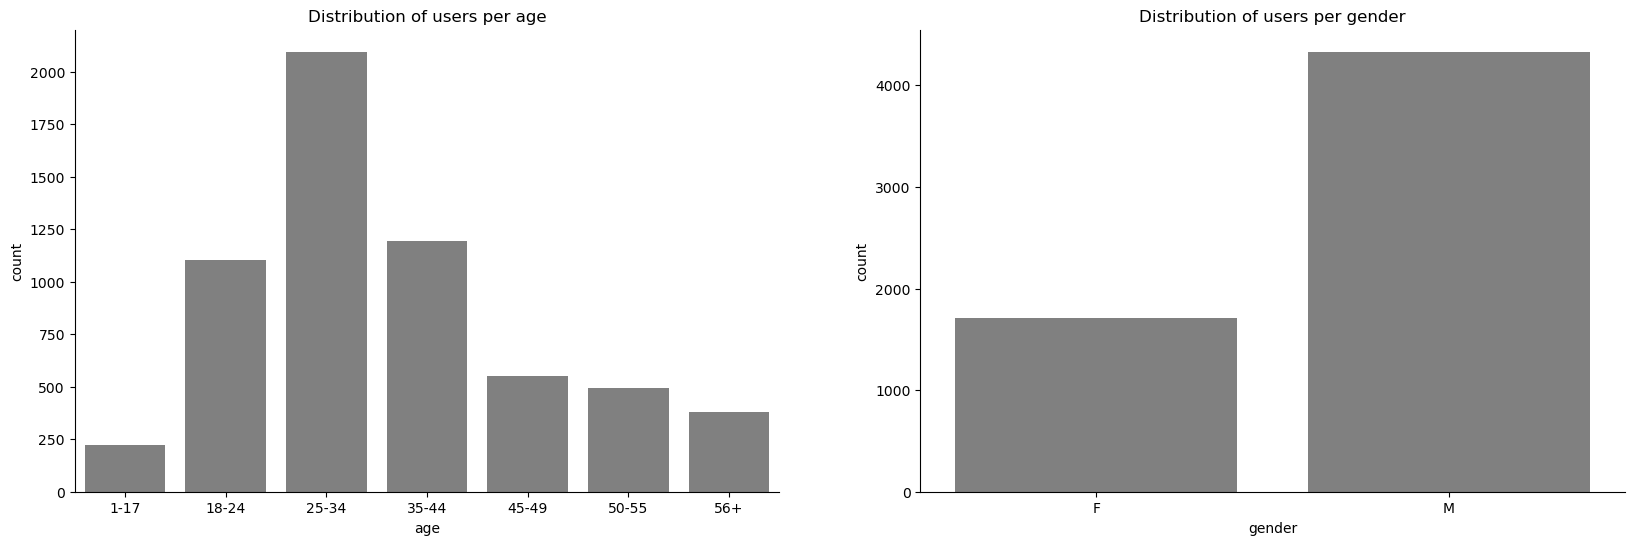

In [17]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per age')
sns.countplot(data=users, x='age', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of users per gender')
sns.countplot(data=users, x='gender', color='grey', ax=ax[1])

## NDCG

In [54]:
def get_kruskal(ndcg_dicts, key_col):
    gender_list = list(ndcg_dicts[key_col].values())
    return stats.kruskal(*gender_list)

In [56]:
for c, ndcg_dict in ndcg_dicts.items():
    kruskal_val = get_kruskal(ndcg_dicts, c)
    print(f'Kruscal-Wallis test for {c}: {kruskal_val}')

Kruscal-Wallis test for age: KruskalResult(statistic=30.334440753045413, pvalue=3.395150151588047e-05)
Kruscal-Wallis test for gender: KruskalResult(statistic=8.307692307692314, pvalue=0.003947751856903446)
Kruscal-Wallis test for usage: KruskalResult(statistic=33.24190476190478, pvalue=9.419705216448917e-06)


### By age and gender

In [49]:
def get_df_from_ndcg_dict(ndcg_dicts, key_col):
    df_ndcg = pd.DataFrame(ndcg_dicts[key_col])
    df_ndcg = df_ndcg.melt()
    df_ndcg.columns = [key_col, 'ndcg']
    return df_ndcg

In [50]:
df_ndcg_age = get_df_from_ndcg_dict(ndcg_dicts, 'age')
df_ndcg_gender = get_df_from_ndcg_dict(ndcg_dicts, 'gender')

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by gender'}, xlabel='gender', ylabel='ndcg'>

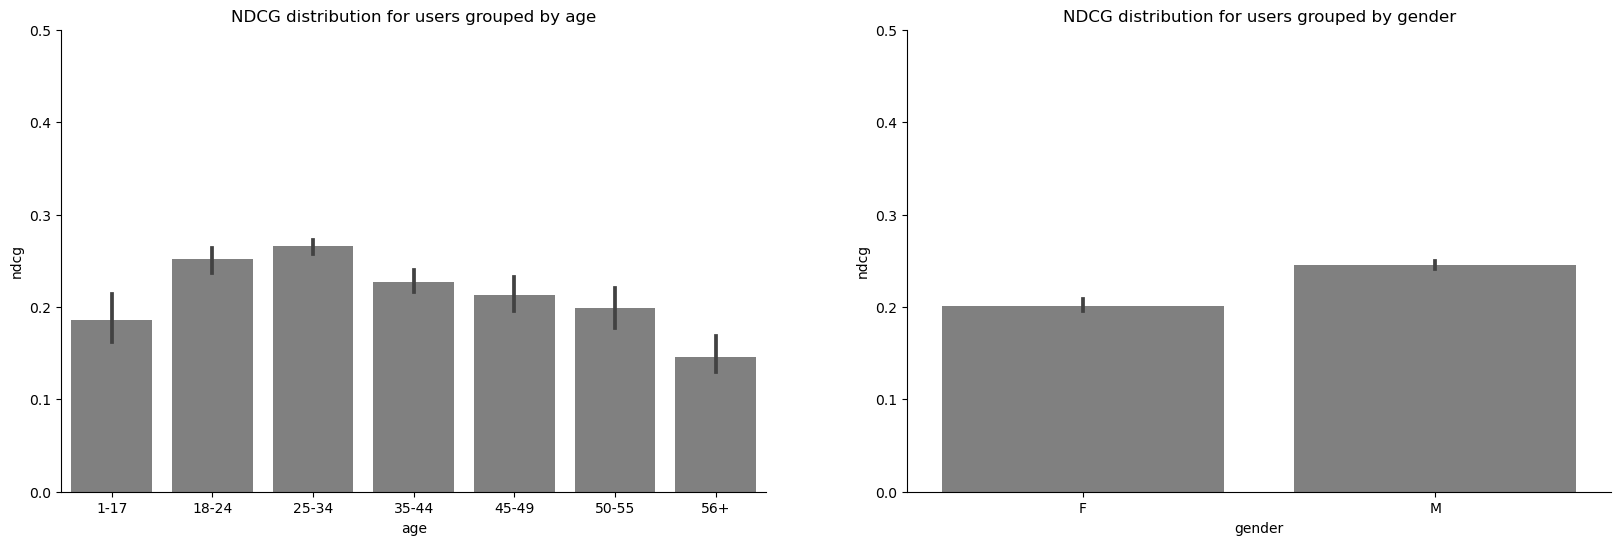

In [52]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('NDCG distribution for users grouped by age')
ax[0].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_age, x='age', y='ndcg', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('NDCG distribution for users grouped by gender')
ax[1].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_gender, x='gender', y='ndcg', color='grey', ax=ax[1])

### By usage

In [58]:
df_ndcg_usage = get_df_from_ndcg_dict(ndcg_dicts, 'usage')

<AxesSubplot: title={'center': 'NDCG distribution for users grouped by usage'}, xlabel='usage', ylabel='ndcg'>

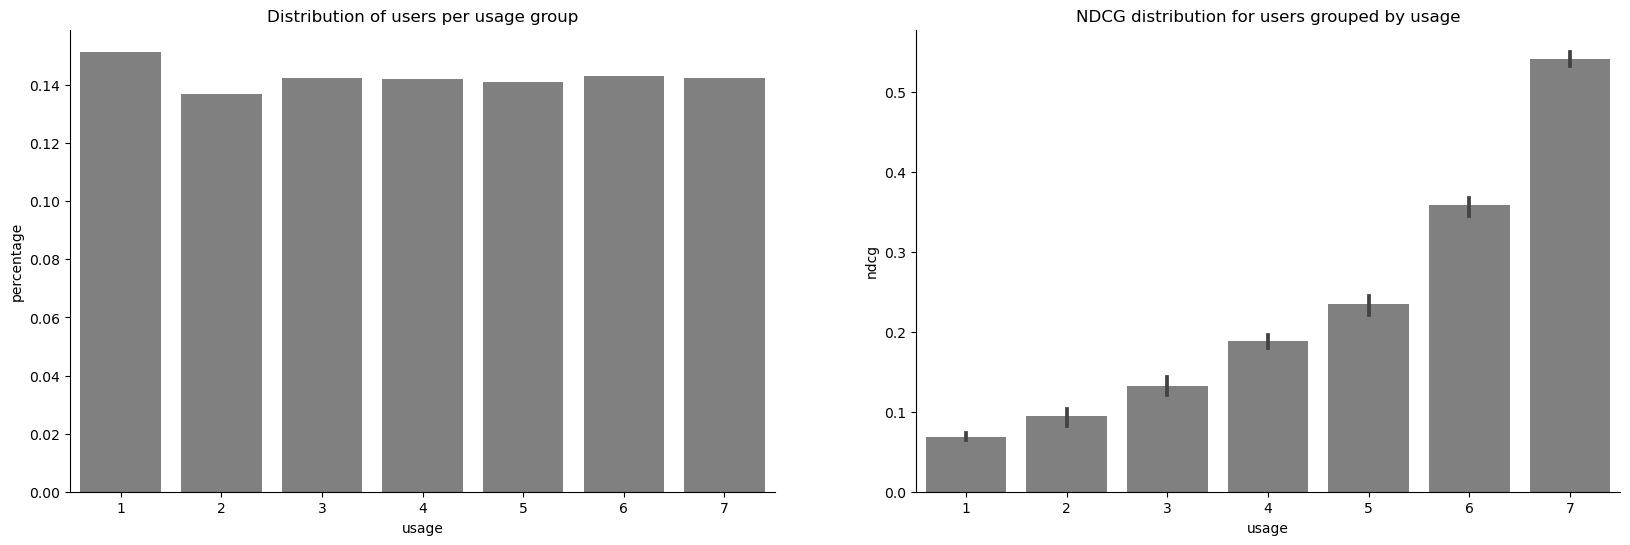

In [66]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per usage group')
sns.barplot(data=popularity_cut_counts, x='usage', y='percentage', color='grey', ax=ax[0], )

ax[1].set_title('NDCG distribution for users grouped by usage')
sns.barplot(data=df_ndcg_usage, x='usage', y='ndcg', color='grey', ax=ax[1])